<a href="https://colab.research.google.com/github/cosineK/PyTorch-Image-classification/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mount drive - allows google collab to have access to the drive where the dataset
#is stored.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load neccessary libraries
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_dataset = "/content/drive/MyDrive/NEU_2/train"
test_dataset = "/content/drive/MyDrive/NEU_2/test"
val_dataset = "/content/drive/MyDrive/NEU_2/valid"

#print("Train dataset: ", os.listdir(train_dataset))
#print("Test dataset: ", os.listdir(test_dataset))
#print("Validation dataset: ", os.listdir(val_dataset))

CLASS_NAMES = os.listdir(train_dataset)

In [ ]:
#show training set images randomly
def shw_img(data_dir, img_num):
  cls_name = os.listdir(data_dir)
  num_rows = int(img_num)
  num_cols = int(img_num)
  fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10, 10))
  for i in range(num_rows):
    for j in range(num_cols):
      class_num = random.randint(0, len(cls_name)-1)
      img_name = random.choice(os.listdir(os.path.join(data_dir, cls_name[class_num])))
      img_path = os.path.join(data_dir, cls_name[class_num], img_name)
      img = mpimg.imread(img_path)

      axarr[i,j].imshow(img, cmap = 'gray')
      axarr[i,j].set_title(cls_name[class_num])
      axarr[i,j].axis('off')

  plt.show()

shw_img(train_dataset, 3)




In [ ]:
#image preprocessing for train dataset and the validation dataset

image_transforms = {
    'training_transform': transforms.Compose([ #initate muliple transformation which be chained
        transforms.Resize((224,224)), #resize each image pixel size to 224 by 224
        transforms.RandomHorizontalFlip(), #flip image horizonatally
        transforms.ColorJitter(), #applies colour transformation
        transforms.RandomRotation(30), #rotates image at angle of 30 degree
        transforms.ToTensor(), #converts to pytorch sensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalizing each channel in the converted data

    ]),

    'validation_transform': transforms.Compose([ #initate muliple transformation which be chained
        transforms.Resize((224,224)), #resize each image pixel size to 224 by 224
        transforms.RandomHorizontalFlip(), #flip image horizonatally
        transforms.ColorJitter(), #applies colour transformation
        transforms.RandomRotation(30), #rotates image at angle of 30 degree
        transforms.ToTensor(), #converts to pytorch sensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalizing each channel in the converted data
    ])
}

In [ ]:
data = {
    'training_transform': datasets.ImageFolder(root=train_dataset, transform=image_transforms['training_transform']),
    'validation_transform': datasets.ImageFolder(root=val_dataset, transform=image_transforms['validation_transform'])
}



print("Training dataset: ", len(data['training_transform']))
print("Validation dataset: ", len(data['validation_transform']))


Training dataset:  1260
Validation dataset:  270


In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 6

load_training_transform = DataLoader(data['training_transform'], batch_size = BATCH_SIZE, shuffle=True)
load_training_validation = DataLoader(data['validation_transform'], batch_size = BATCH_SIZE, shuffle=True)

In [ ]:
#loading pre-trained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #check available device GPU/CPU and run on allocated avaiable device.
#print(device)
model = models.resnet50(pretrained = True).to(device) #load resnet-50 and move to specified device GPU/CPU
summary(model, (3, 224, 224)) #display resnet-50 model architecture including trainable parameters

In [ ]:
#building model

for param in model.parameters(): #loop through resnet-50 parameters
  param.requires_grad = False #set required grad to false. freezes all pretrained
                              #layers in the pretrained model

feature_num = model.fc.in_features #extract resnet-50 feature inputs

#initates customised FC sequence
#activation function
model.fc = nn.Sequential(
    nn.Linear(feature_num, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)

# pre-trained resnet-50 layers and customised layers to device
model = model.to(device)
summary(model, (3, 224, 224))

In [ ]:
#using cross entropy to calculate loss function
#optimisers using stochastic gradient descent
loss_function = torch.nn.CrossEntropyLoss()
grad_des = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epoch_number = 30 #declare epoch number
loss_tr = [] #declaree "loss_tr" as list
loss_val = [] #declaree "loss_val" as list

for epoch in range(epoch_number): #loop through number of epoch
    losses_tr = 0 #initlize losses_tr to 0
    losses_val = 0 #initlize losses_val to 0

    #mModel training loop
    #model is trained in batches of images
    #Based on the training parameters are updated using loss calculation
    #then calculate average loss
    #this is also the case for the validation dataset
    model.train()
    for images, labels in load_training_transform:
      images = images.to(device)
      labels = labels.to(device)
      grad_des.zero_grad()
      outputs = model(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      grad_des.step()
      losses_tr += loss.item() * images.size(0)
      losses_tr /= len(load_training_transform.dataset)
      loss_tr.append(losses_tr)

    # loop for validation training
    model.eval()
    for images, labels in load_training_validation:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      loss = loss_function(outputs, labels)
      losses_val += loss.item() * images.size(0)
      losses_val /= len(load_training_validation.dataset)
      loss_val.append(losses_val)

    # Print number of epoch trainied + training loss and validation loss
    print(f'Epoch [{epoch + 1}/{epoch_number}], Training Loss: {losses_tr:.4f}, Validation Loss: {losses_val:.4f}')


In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
#plt.plot(loss_tr,label="train")
plt.plot(loss_val, 'g', label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_tr,label="train")
#plt.plot(loss_val,label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
test_Model = transforms.Compose([ #initate muliple transformation which be chained
    transforms.Resize((224,224)), #resize image to size 224 by 224 pixels
    transforms.ToTensor(),#converts to pytorch sensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #normalizing each channel in the converted data
])

testing = datasets.ImageFolder(test_dataset, transform=test_Model) #load and classify image from testing dataset
load_testing = DataLoader(testing, batch_size=32, shuffle=True)#create dataloader and process in batches of 32 using testing data as input

model.eval()#set model in evaluation mode

with torch.no_grad(): #speed up evaluation process by disabling gradient calculation
    correct = 0 #intialise correct to 0
    total = 0 #intialise total to 0
    y_prediction = [] #define/create y_pred as a list
    trueY = [] #define/create trueY as a list
    for images, labels in load_testing: #loop over the load_testing folder
        images = images.to(device) #moves images to device
        labels = labels.to(device) #moves labels to device
        outputs = model(images) #passes images in batches to model
        _, predicted = torch.max(outputs.data, 1) #predict classvia finding class indices
        total += labels.size(0) #increment count by 32 =  batch size
        correct += (predicted == labels).sum().item() #calculate correctly predicted images in the batch
        y_prediction.extend(predicted.cpu().numpy()) #append to list
        trueY.extend(labels.cpu().numpy()) #append to list

    print('Model Accuracy: {} %'.format(round((100 * correct / total),2))) #calculate and print model percentrage accuracy

Model Accuracy: 95.93 %


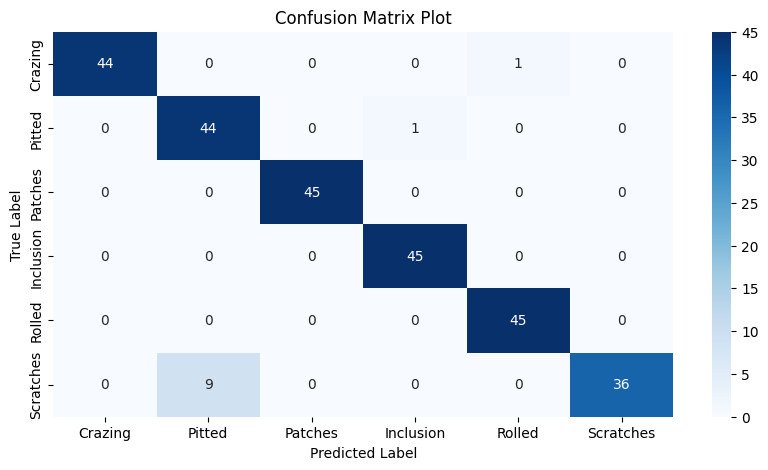

              precision    recall  f1-score   support

     Crazing       1.00      0.98      0.99        45
      Pitted       0.83      0.98      0.90        45
     Patches       1.00      1.00      1.00        45
   Inclusion       0.98      1.00      0.99        45
      Rolled       0.98      1.00      0.99        45
   Scratches       1.00      0.80      0.89        45

    accuracy                           0.96       270
   macro avg       0.96      0.96      0.96       270
weighted avg       0.96      0.96      0.96       270



In [ ]:
# Plot confusion matrix
conf_max = confusion_matrix(trueY, y_prediction)
plt.figure(figsize=(10,5))
sns.heatmap(conf_max, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix Plot')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print(classification_report(trueY, y_prediction, target_names=CLASS_NAMES))

# New Section